# Atelier : Prédiction floue du risque de panne d’une machine industrielle
#### Réalisé par : Mohamed Rida Lajghal  IID3

<hr>
<hr>

### Contexte:
#### Les ingénieurs de maintenance veulent estimer le risque de panne d’une machine.
#### Cependant, les indicateurs collectés sont souvent imprécis : ▪ “température élevée”, “vibrations légères”, “machine récente”…
#### L'objectif est de créer un modèle capable de gérer cette incertitude grâce à la logique floue, puis d’entraîner un modèle de Machine Learning pour automatiser la prédiction.

In [60]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Modélisation floue :

In [51]:
# Définition des variables floues
# Entrées
temperature = ctrl.Antecedent(np.arange(0, 101, 1), 'temperature')
vibration = ctrl.Antecedent(np.arange(0, 11, 0.1), 'vibration')
age = ctrl.Antecedent(np.arange(0, 21, 1), 'age')

# Sortie
risque = ctrl.Consequent(np.arange(0, 11, 0.1), 'risque')

In [52]:
# Fonctions d’appartenance
# Température
temperature['basse'] = fuzz.trimf(temperature.universe, [0, 0, 40])
temperature['normale'] = fuzz.trimf(temperature.universe, [30, 50, 70])
temperature['élevée'] = fuzz.trimf(temperature.universe, [60, 100, 100])

# Vibration
vibration['faible'] = fuzz.trimf(vibration.universe, [0, 0, 4])
vibration['moyenne'] = fuzz.trimf(vibration.universe, [2, 5, 8])
vibration['forte'] = fuzz.trimf(vibration.universe, [6, 10, 10])

# Âge
age['neuf'] = fuzz.trimf(age.universe, [0, 0, 7])
age['moyen'] = fuzz.trimf(age.universe, [5, 10, 15])
age['ancien'] = fuzz.trimf(age.universe, [12, 20, 20])

# Risque
risque['faible'] = fuzz.trimf(risque.universe, [0, 0, 4])
risque['moyen'] = fuzz.trimf(risque.universe, [2, 5, 8])
risque['élevé'] = fuzz.trimf(risque.universe, [6, 10, 10])

c:\Users\redag\AppData\Local\Programs\Python\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


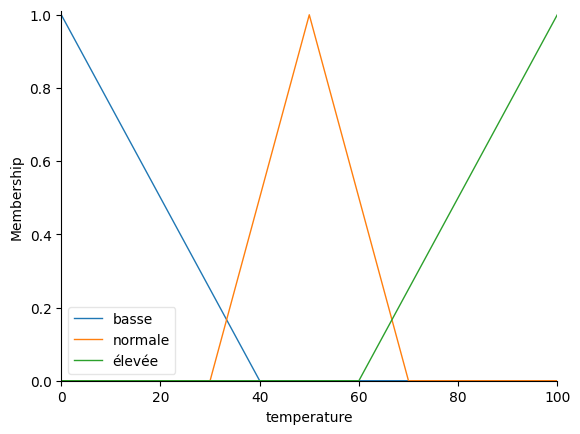

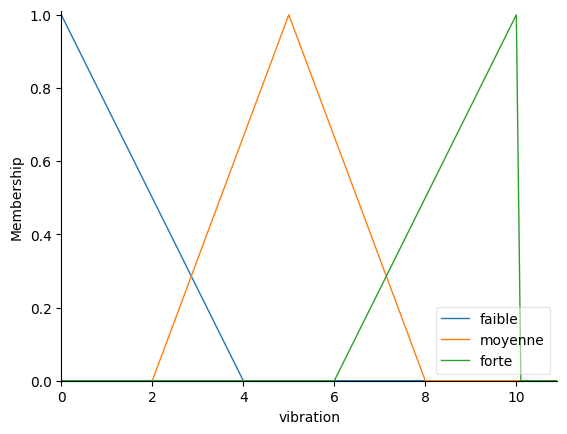

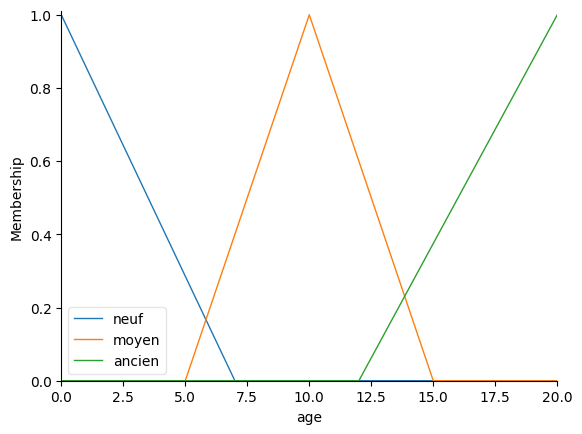

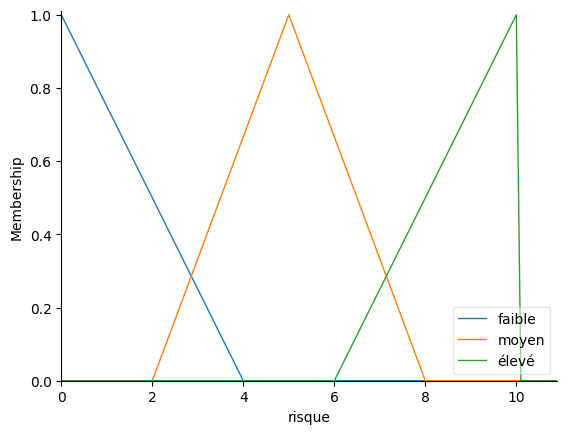

In [53]:
# Visualisation des ensembles flous
temperature.view()
vibration.view()
age.view()
risque.view()

In [54]:
# Définition des règles floues
rule1 = ctrl.Rule(temperature['élevée'] | vibration['forte'], risque['élevé'])
rule2 = ctrl.Rule(age['ancien'] & vibration['moyenne'], risque['moyen'])
rule3 = ctrl.Rule(temperature['basse'] & vibration['faible'] & age['neuf'], risque['faible'])
rule4 = ctrl.Rule(temperature['normale'] & age['moyen'], risque['moyen'])

rule5 = ctrl.Rule(age['ancien'] & vibration['forte'], risque['élevé'])
rule6 = ctrl.Rule(age['ancien'] & temperature['élevée'], risque['élevé'])
rule7 = ctrl.Rule(vibration['moyenne'] & temperature['élevée'], risque['moyen'])
rule8 = ctrl.Rule(temperature['basse'] & age['ancien'], risque['moyen'])
rule9 = ctrl.Rule(vibration['faible'] & temperature['normale'], risque['faible'])

rule_default = ctrl.Rule(
    antecedent=(temperature['basse'] | temperature['normale'] | temperature['élevée']) &
               (vibration['faible'] | vibration['moyenne'] | vibration['forte']) &
               (age['neuf'] | age['moyen'] | age['ancien']),
    consequent=risque['moyen']
)


In [55]:
# Création et simulation du contrôleur flou
risque_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4 , rule5, rule6, rule7, rule8, rule9, rule_default])
risque_sim = ctrl.ControlSystemSimulation(risque_ctrl)

Risque prédicté (flou) : 5.969282730992158


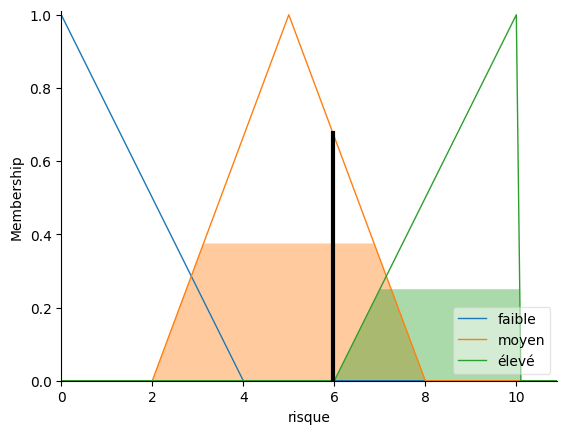

In [56]:
risque_sim.input['temperature'] = 70
risque_sim.input['vibration'] = 6
risque_sim.input['age'] = 15

risque_sim.compute()
print("Risque prédicté (flou) :", risque_sim.output['risque'])
risque.view(sim=risque_sim)

## Machine Learning

In [ ]:
# Génération de 2000 échantillons aléatoires
n_samples = 2000
data = np.random.rand(n_samples, 3)
data[:, 0] *= 100   # température
data[:, 1] *= 10    # vibration
data[:, 2] *= 20    # âge

# Calcul des risques pour chaque échantillon
risques = []
for t, v, a in data:
    risque_sim.input['temperature'] = t
    risque_sim.input['vibration'] = v
    risque_sim.input['age'] = a
    risque_sim.compute()
    risques.append(risque_sim.output['risque'])

X = data
y = np.array(risques)

In [ ]:
# Entraînez un modèle de régression pour prédire le risque à partir des trois entrées.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE :", mean_squared_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))

MSE : 0.01871761462055167
R² : 0.9843108269360146


## Interprétation et Analyse:

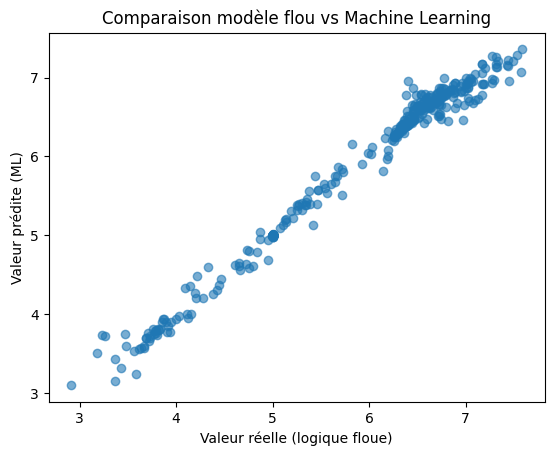

In [ ]:
# Comparez les prédictions floues et celles du modèle ML
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Valeur réelle (logique floue)")
plt.ylabel("Valeur prédite (ML)")
plt.title("Comparaison modèle flou vs Machine Learning")
plt.show()

### Quels sont les avantages de chaque approche ?
##### => La logique floue offre transparence et interprétabilité, idéale pour expliquer les décisions.
##### => Le machine learning privilégie la précision et la généralisation grâce à l’apprentissage des données.